# Латентное пространство в VAE автоенкодере

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import CelebA
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


Рекомендую прочитать оригинальную статью [Variational AutoEncoder](https://arxiv.org/pdf/1312.6114.pdf) (VAE, D.P. Kingma et. al., 2013)

**Замечание** Для того, чтобы реализовать VAE, прочитайте данную ниже небольшаую теоретическую справку и выполните задание в конце.

### Кроссэнтропия
В теории информации перекрёстная энтропия (или *кроссэнтропия*) между двумя распределениями вероятностей измеряет среднее число бит, необходимых для опознания события из набора возможностей, если используемая схема кодирования базируется на заданном распределении вероятностей $q$, вместо «истинного» распределения $p$.  
Кроссэнтропией распределения $q$ по отношению к распределению $p$ называется величина:  
$$H(p, q) \stackrel{\mathrm{df}}{\;=\;} \mathrm{E}_p[-\log q] = -\sum_x p(x)\, \log q(x) = H(p) + D_{KL}(p \| q),$$  
<!-- или  $$H(p, q) = -\int\limits_X p(x)\, \log q(x)\, dx.$$ -->
где $H(p)$ - энтропия распределения $p$, $D_{KL}(p \| q)$ - дивергенция Кульбака-Лейблера. Можно показать, что энтропия $H(p)$ всегда меньше чем кроссэнтропия $H(p, q)$. Таким образом, дивергенция Кульбака-Лейблера - неотрицательная величина.



### Дивергенция Кульбака-Лейблера
Расхождение (дивергенция) Ку́льбака-Ле́йблера (англ. Kullback–Leibler divergence), РКЛ, — информационное расхождение, различающая информация, информационный выигрыш, относительная энтропия (англ. relative entropy). Это неотрицательнозначный функционал, являющийся несимметричной мерой удалённости друг от друга двух вероятностных распределений $p$ и $q$, определённых на общем пространстве элементарных событий:  
$$D_{\mathrm{KL}}(p\parallel q) = \sum_x p(x) \, \log \frac{p(x)}{q(x)} \,$$

### Дивергенция Кульбака-Лейблера для многомерного нормального распределения
Допустим, что мы имеем два многомерных нормальных распределения, со средними $\mu_0, \mu_1$ и с (обратимыми) матрицами ковариаций $\Sigma_0, \Sigma_1$. Если два распределения имеют одинаковую размерность $k$, то РКЛ между распределениями следующее:  
$$D_\text{KL}(\mathcal{N}_0 \parallel  \mathcal{N}_1) = { 1 \over 2 } \left( \mathrm{tr} \left( \Sigma_1^{-1} \Sigma_0 \right) + \left( \mu_1 - \mu_0\right)^\top \Sigma_1^{-1} ( \mu_1 - \mu_0 ) - k + \ln \left( { \det \Sigma_1 \over \det \Sigma_0  } \right)  \right).$$


Упростите данное выражение для случая, которое используется в VAE, когда компоненты векторов независимы, т.е. матрицы ковариации диагональны. Также упростите выражение, когда второе распределение $\mathcal{N}_1$ является стандартным, т.е. с нулевыми средними и единичными дисперсиями.

В данном задании необходимо:

1. Реализовать обычный автоенкодер и VAE автоенкодер с архитектурой как на рисунке:
<img src='images/mnist_vae.png' width=300>

2. Обучить его на обучающей выборке из базы данных MNIST и после этого, воспользоваться энкодером, чтобы преобразовать картинки из тестовой выборки в латентное пространство, получить рисунок похожий на рисунок ниже для обоих автоенкодеров и сравнить результаты:
<img src='images/vae_mnist_cloud.png' width=300>

In [1]:
# Hyper-parameters
input_size = 784
batch_size = 100
num_epochs = 50
learning_rate = 0.001

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../../data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data',
                                          train=False,
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size * 10,
                                          shuffle=False)

cpu


# Автоенкодер (AЕ)

In [2]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 250),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.ReLU(),
            nn.Linear(500, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Инициализация модели, функции потерь и оптимизатора для AЕ

In [3]:
model_ae = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_ae.parameters(), lr=learning_rate)

# Обучение AЕ

In [4]:
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.view(-1, 28 * 28).to(device)
        
        # Forward pass
        outputs = model_ae(images)
        loss = criterion(outputs, images)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch + 1) % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item()))

Epoch [10/50], Loss: 0.0356
Epoch [20/50], Loss: 0.0336
Epoch [30/50], Loss: 0.0302
Epoch [40/50], Loss: 0.0309
Epoch [50/50], Loss: 0.0312


# Тестирование AЕ

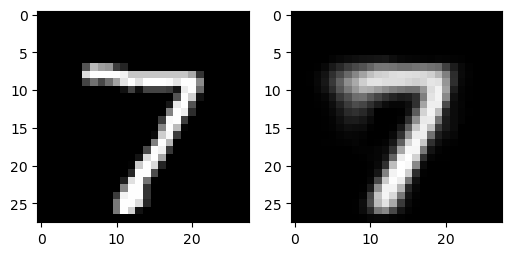

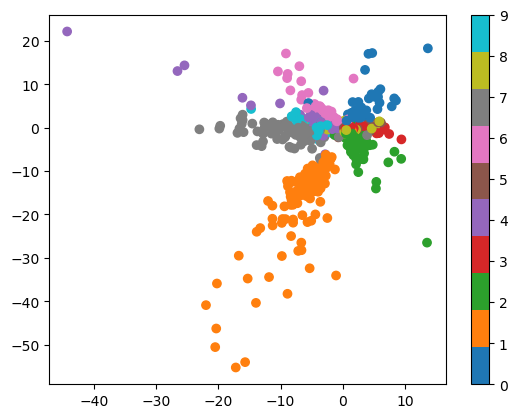

In [5]:
# Test the model
with torch.no_grad():
    for (images, _) in test_loader:
        images = images.view(-1, 28 * 28).to(device)
        outputs = model_ae(images)
        break

images = images.cpu()
output = outputs.cpu()

orig_img = images[0].detach().numpy().reshape(28, 28)
img = output[0].detach().numpy().reshape(28, 28)
fig, axs = plt.subplots(1, 2, figsize=(6, 12))
axs[0].imshow(orig_img, cmap='gray')
axs[1].imshow(img, cmap='gray')
plt.show()

# Latent space
with torch.no_grad():
    for (images, labels) in test_loader:
        images = images.view(-1, 28 * 28).to(device)
        latent = model_ae.encoder(images)
        break

latent = latent.cpu()
latent_repr = latent.detach().numpy()
plt.scatter(latent_repr[:, 0], latent_repr[:, 1], c=labels, cmap='tab10')
plt.colorbar()
plt.show()

# Вариационный автоенкодер (VAE)

In [37]:
class EncoderVAE(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, latent_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.latent_size = latent_size
        
        self.model = nn.Sequential(nn.Linear(input_size, hidden_size1), 
                                   nn.ReLU(), 
                                   nn.Linear(hidden_size1, hidden_size2),
                                   nn.ReLU()
                                  )
        self.mean_layer = nn.Linear(hidden_size2, latent_size)
        self.var_layer = nn.Linear(hidden_size2, latent_size)
        self.kl = 0
        
    def forward(self, X):
        X1 = self.model(X)
        mean = self.mean_layer(X1)
        var = torch.exp(0.5 * self.var_layer(X1))
        eps = torch.randn_like(var)
        lat = mean + var * eps
        self.kl = - 0.5 * (1 + torch.log(var ** 2) - mean ** 2 - var ** 2).sum()
        return lat

    
class DecoderVAE(nn.Module):
    def __init__(self,  input_size, hidden_size1, hidden_size2, latent_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.latent_size = latent_size

        self.model = nn.Sequential(nn.Linear(latent_size, hidden_size2),
                                   nn.ReLU(), 
                                   nn.Linear(hidden_size2, hidden_size1),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size1, input_size)
                                  )
    def forward(self, X):
        return self.model(X)
    
    
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, latent_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.latent_size = latent_size
        self.encoder = EncoderVAE(input_size, hidden_size1, hidden_size2, latent_size)
        self.decoder = DecoderVAE(input_size, hidden_size1, hidden_size2, latent_size)
        
    def forward(self, X):
        latent = self.encoder(X)
        return self.decoder(latent)

# Инициализация модели, функции потерь и оптимизатора для VAE 

In [38]:
model_vae = VAE(input_size=784, hidden_size1=500, hidden_size2=250, latent_size=2).to(device)
criterion_vae = nn.MSELoss(reduction="sum")
optimizer_vae = torch.optim.Adam(model_vae.parameters())

# Обучение VAЕ

In [39]:
num_epochs = 100
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28 * 28).to(device)
        labels = images.to(device)
        
        outputs = model_vae(images)
        loss = criterion_vae(outputs, labels) + model_vae.encoder.kl
        
        optimizer_vae.zero_grad()
        loss.backward()
        optimizer_vae.step()
        
    if (epoch+1) % 10 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}' 
                .format(epoch+1, num_epochs, loss.item()))

Epoch [10/100], Loss: 3302.9316
Epoch [20/100], Loss: 3277.9297
Epoch [30/100], Loss: 3363.1221
Epoch [40/100], Loss: 3322.9199
Epoch [50/100], Loss: 3352.3271
Epoch [60/100], Loss: 3259.7849
Epoch [70/100], Loss: 3323.0381
Epoch [80/100], Loss: 3356.7236
Epoch [90/100], Loss: 3191.2490
Epoch [100/100], Loss: 3195.7610


# Тестирование VAЕ

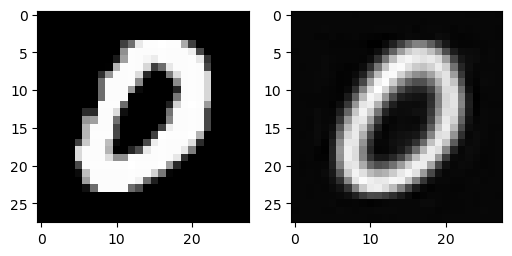

tensor(0)


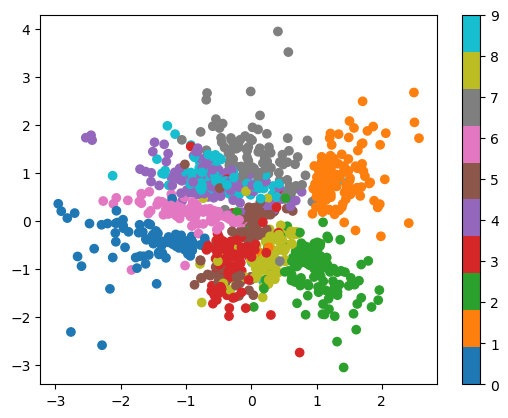

In [40]:
# Test the model
for (images, labels) in train_loader:
    break
images = images.reshape(-1, 28 * 28).to(device)
output = model_vae(images)
images = images.cpu()
output = output.cpu()

orig_img = images[0].detach().numpy().reshape(28, 28)
img = output[0].detach().numpy().reshape(28, 28)
fig, axs = plt.subplots(1, 2, figsize=(6, 12))
axs[0].imshow(orig_img, cmap='gray')
axs[1].imshow(img, cmap='gray')
plt.show()
print(labels[0])

# Latent space
for (images, labels) in test_loader:
    break
images = images.reshape(-1, 28 * 28).to(device)
latent = model_vae.encoder(images)
latent = latent.cpu()
latent_pepr = latent.detach().numpy()
plt.scatter(latent_pepr[:,0], latent_pepr[:,1], c=labels, cmap='tab10')
plt.colorbar()
plt.show()

3. Построить в латентном пространстве на квадрате [-2, 2]x[-2, 2] сетку из 15x15 значений и построить с помощью декодера картинки цифр для каждого значения из этой сетки и получить рисунок похожий на рисунок ниже:
<img src='images/vae_mnist_digits.png' width=300>

# AE

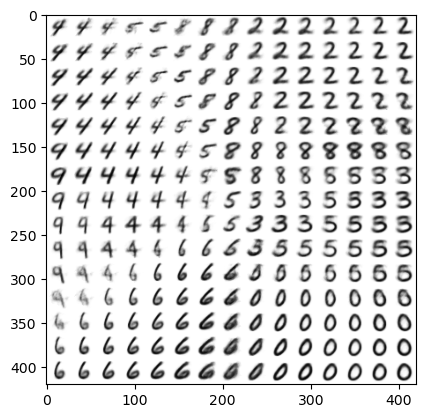

In [36]:
grid_size = 15
latent_values_x = np.linspace(-2, 2, grid_size)
latent_values_y = np.linspace(-2, 2, grid_size)
grid_x, grid_y = np.meshgrid(latent_values_x, latent_values_y)
latent_grid = np.vstack([grid_x.flatten(), grid_y.flatten()]).T
latent_grid_tensor = torch.FloatTensor(latent_grid).to(device)
decoded_images = model_ae.decoder(latent_grid_tensor)
decoded_images = decoded_images.view(-1, 1, 28, 28).cpu().detach().numpy()

big_image = np.zeros((15 * 28, 15 * 28))
for i in range(15):
    for j in range(15):
        big_image[i*28 : (i+1)*28, j*28 : (j+1)*28] = 1 - decoded_images[15*i + j].reshape(28, 28)

plt.imshow(big_image, cmap='gray')
plt.show()

# VAE

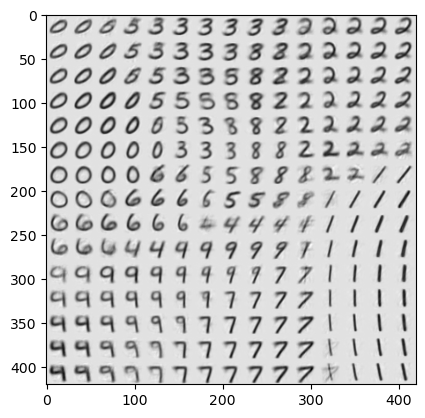

In [41]:
grid_size = 15
latent_values_x = np.linspace(-2, 2, grid_size)
latent_values_y = np.linspace(-2, 2, grid_size)
grid_x, grid_y = np.meshgrid(latent_values_x, latent_values_y)
latent_grid = np.vstack([grid_x.flatten(), grid_y.flatten()]).T
latent_grid_tensor = torch.FloatTensor(latent_grid).to(device)
decoded_images = model_vae.decoder(latent_grid_tensor)
decoded_images = decoded_images.view(-1, 1, 28, 28).cpu().detach().numpy()

big_image = np.zeros((15 * 28, 15 * 28))
for i in range(15):
    for j in range(15):
        big_image[i * 28 : (i + 1) * 28, j * 28 : (j + 1) * 28] = 1 - decoded_images[15 * i + j].reshape(28, 28)

plt.imshow(big_image, cmap='gray')
plt.show()